In [ ]:
!pip install transformers

In [ ]:
!pip install huggingface_hub

In [ ]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199773 sha256=5f4b862c2c94d8174fca2184d88ab9f94cdfcb43aff1c775bef93ce889ba066a
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-16GB


In [ ]:
import glob
import pandas as pd
import csv
import re
import math
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from transformers import AutoTokenizer, AutoModel, AdamW, GPT2ForSequenceClassification
import torch

import fasttext
from huggingface_hub import hf_hub_download
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
import matplotlib.pyplot as plt

import pandas as pd
import json

# Load RoGPT2 tokenizer

In [ ]:
# load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("readerbench/RoGPT2-base")
tokenizer.pad_token = tokenizer.eos_token
print(tokenizer.pad_token)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/563 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/814 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/985k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/542k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

<|endoftext|>


In [ ]:
tokenizer

GPT2TokenizerFast(name_or_path='readerbench/RoGPT2-base', vocab_size=50257, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}

# Utils

In [ ]:
def transform_column(df_column):
  scaler = MinMaxScaler()
  scores = np.array(df_column)
  scores = scores.reshape(-1,1)
  scaler.fit(scores)
  scores = scaler.transform(scores)
  scores = np.float32(scores)
  return scores

In [ ]:
model_path = hf_hub_download(repo_id="facebook/fasttext-language-identification", filename="model.bin")
model = fasttext.load_model(model_path)

def is_romanian_post(row):
  if model.predict(change_n_to_space(row["title"]))[0][0] == '__label__ron_Latn':
      return True
  return False

def change_n_to_space(text):
  return text.replace('\n', ' ')

model.bin:   0%|          | 0.00/1.18G [00:00<?, ?B/s]

# Load dataset

## Romania subreddit

In [ ]:
df_romania = pd.read_json('Romania_submissions (1).json',orient='index')
df_romania = df_romania.reset_index()
df_romania = df_romania.rename(columns={'index':'title', 0:'content', 1: 'num_comments', 2:'score', 3:'date'})
# Combine columns.
df_romania['sum_score'] = df_romania['num_comments'] + df_romania['score']
df_romania['full_text'] = df_romania['title'] + '. ' + df_romania['content']

# Transform.
df_romania['num_comments'] = transform_column(df_romania['num_comments'])
df_romania['score'] = transform_column(df_romania['score'])
df_romania['sum_score'] = transform_column(df_romania['sum_score'])

df_romania

,title,content,num_comments,score,date,sum_score,full_text
0,"Romania declares witchcraft a profession, FINA...",,0.013095,0.056034,2011-01-04 23:51:48,0.038662,"Romania declares witchcraft a profession, FINA..."
1,I'm an American who is about to Study Abroad i...,I'll be attending Babes-Bolyai this coming sem...,0.020238,0.036638,2011-01-06 07:31:18,0.035528,I'm an American who is about to Study Abroad i...
2,Dead birds were dead drunk,,0.002381,0.049569,2011-01-13 14:43:21,0.026123,Dead birds were dead drunk.
3,RObotzi - serial animat romanesc,,0.010714,0.032328,2011-01-24 02:26:07,0.025078,RObotzi - serial animat romanesc.
4,Paraziții - În Jur (altă variantă decât cea de...,,0.004762,0.028017,2011-01-26 13:26:21,0.017764,Paraziții - În Jur (altă variantă decât cea de...
...,...,...,...,...,...,...,...
29995,Hai sa facem un exercitiu de democratie. Vreti...,,0.004762,0.000000,2015-05-22 00:00:30,0.004180,Hai sa facem un exercitiu de democratie. Vreti...
29996,[Rant] Prietenul m-a parasit din cauza religie...,Am avut un prieten timp de cateva zile de care...,0.164286,0.062500,2015-05-22 00:10:53,0.174504,[Rant] Prietenul m-a parasit din cauza religie...
29997,Unui român care nu s-a mai bărbierit din ianua...,,0.000000,0.071121,2015-05-22 04:55:23,0.034483,Unui român care nu s-a mai bărbierit din ianua...
29998,Soluţie tipic românească. Medicamentele fără r...,,0.004762,0.051724,2015-05-22 08:21:00,0.029258,Soluţie tipic românească. Medicamentele fără r...


In [ ]:
df_romania = df_romania[df_romania.apply(is_romanian_post, axis=1)]
df_romania

,title,content,num_comments,score,date,sum_score,full_text
3,RObotzi - serial animat romanesc,,0.010714,0.032328,2011-01-24 02:26:07,0.025078,RObotzi - serial animat romanesc.
4,Paraziții - În Jur (altă variantă decât cea de...,,0.004762,0.028017,2011-01-26 13:26:21,0.017764,Paraziții - În Jur (altă variantă decât cea de...
6,Muzica romaneasca.......Ce-au trecut anii........,,0.020238,0.034483,2011-01-30 23:46:30,0.034483,Muzica romaneasca.......Ce-au trecut anii........
7,Muzica romaneasca de top-ce au trecut anii.......,,0.004762,0.028017,2011-01-30 23:28:51,0.017764,Muzica romaneasca de top-ce au trecut anii.......
8,Grigorescu Eva Maria,,0.002381,0.008621,2011-02-01 01:37:08,0.006270,Grigorescu Eva Maria.
...,...,...,...,...,...,...,...
29994,UE pare să piardă lupta cu Rusia pentru Republ...,,0.009524,0.043103,2015-05-21 23:40:49,0.029258,UE pare să piardă lupta cu Rusia pentru Republ...
29996,[Rant] Prietenul m-a parasit din cauza religie...,Am avut un prieten timp de cateva zile de care...,0.164286,0.062500,2015-05-22 00:10:53,0.174504,[Rant] Prietenul m-a parasit din cauza religie...
29997,Unui român care nu s-a mai bărbierit din ianua...,,0.000000,0.071121,2015-05-22 04:55:23,0.034483,Unui român care nu s-a mai bărbierit din ianua...
29998,Soluţie tipic românească. Medicamentele fără r...,,0.004762,0.051724,2015-05-22 08:21:00,0.029258,Soluţie tipic românească. Medicamentele fără r...


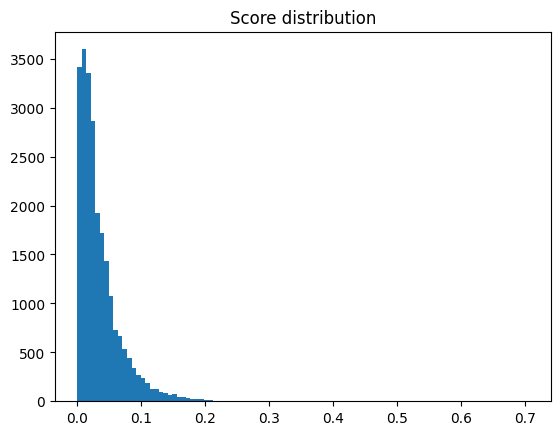

In [ ]:
plt.hist(df_romania['sum_score'], bins=100)
plt.title('Score distribution')
plt.show()

## Cluj subreddit

In [ ]:
df_cluj = pd.read_json('cluj_submissions (1).json',orient='index')
df_cluj = df_cluj.reset_index()
df_cluj = df_cluj.rename(columns={'index':'title', 0:'content', 1: 'num_comments', 2:'score', 3:'date'})

# Combine columns.
df_cluj['sum_score'] = df_cluj['num_comments'] + df_cluj['score']
df_cluj['full_text'] = df_cluj['title'] + '. ' + df_cluj['content']

# Transform.
df_cluj['num_comments'] = transform_column(df_cluj['num_comments'])
df_cluj['score'] = transform_column(df_cluj['score'])
df_cluj['sum_score'] = transform_column(df_cluj['sum_score'])
df_cluj

,title,content,num_comments,score,date,sum_score,full_text
0,"Gheorgheni, in seara asta",,0.248322,1.000000,2023-10-06 22:49:39,1.000000,"Gheorgheni, in seara asta."
1,"As a german, I cannot believe this",,0.432886,0.762408,2022-10-01 20:03:37,0.833497,"As a german, I cannot believe this."
2,Conversatie cu vecinul de jos pe care nici nu ...,,0.412752,0.733896,2023-05-30 10:05:32,0.801175,Conversatie cu vecinul de jos pe care nici nu ...
3,"Buna ziua, suntem studenti UMF Medicina dentar...",Oferim următoarele servicii:\n-Consultații\n-D...,0.312081,0.665259,2023-10-12 09:11:34,0.708129,"Buna ziua, suntem studenti UMF Medicina dentar..."
4,Intre timp apartamentele din Cluj:,,0.036913,0.652587,2022-02-10 09:00:32,0.616063,Intre timp apartamentele din Cluj:.
...,...,...,...,...,...,...,...
975,"Cel mai curat,linistit, lipsit de poluare cart...",,0.120805,0.001056,2022-08-23 20:44:32,0.036239,"Cel mai curat,linistit, lipsit de poluare cart..."
976,Salutare! Îmi puteți recomanda un ONG prin Clu...,,0.036913,0.001056,2022-06-13 23:07:00,0.011753,Salutare! Îmi puteți recomanda un ONG prin Clu...
977,Consultant financiar personal?,Tot ce gasesc pe google sunt firme de contabil...,0.083893,0.001056,2022-01-30 08:44:03,0.025465,Consultant financiar personal?. Tot ce gasesc ...
978,Cum dau de un baiat de la Pata Rat?,"Salut,\n\n&#x200B;\n\nStau in Mihai Viteazu si...",0.070470,0.000000,2021-10-26 17:35:40,0.020568,"Cum dau de un baiat de la Pata Rat?. Salut,\n\..."


In [ ]:
df_cluj = df_cluj[df_cluj.apply(is_romanian_post, axis=1)]
df_cluj

,title,content,num_comments,score,date,sum_score,full_text
0,"Gheorgheni, in seara asta",,0.248322,1.000000,2023-10-06 22:49:39,1.000000,"Gheorgheni, in seara asta."
2,Conversatie cu vecinul de jos pe care nici nu ...,,0.412752,0.733896,2023-05-30 10:05:32,0.801175,Conversatie cu vecinul de jos pe care nici nu ...
3,"Buna ziua, suntem studenti UMF Medicina dentar...",Oferim următoarele servicii:\n-Consultații\n-D...,0.312081,0.665259,2023-10-12 09:11:34,0.708129,"Buna ziua, suntem studenti UMF Medicina dentar..."
4,Intre timp apartamentele din Cluj:,,0.036913,0.652587,2022-02-10 09:00:32,0.616063,Intre timp apartamentele din Cluj:.
5,Ceva titlu,,0.093960,0.616684,2022-11-18 12:37:28,0.599412,Ceva titlu.
...,...,...,...,...,...,...,...
972,De ce proprietarii vând doar prin agenții?,Căutând prin anunțurile imobiliare observ că 9...,0.154362,0.001056,2022-10-01 19:07:24,0.046033,De ce proprietarii vând doar prin agenții?. Că...
974,"Cei care faceti sala, ce sala imi puteti recom...",As vrea sa ma apuc si eu de sala si nu stiu la...,0.255034,0.001056,2022-08-27 17:32:24,0.075416,"Cei care faceti sala, ce sala imi puteti recom..."
975,"Cel mai curat,linistit, lipsit de poluare cart...",,0.120805,0.001056,2022-08-23 20:44:32,0.036239,"Cel mai curat,linistit, lipsit de poluare cart..."
976,Salutare! Îmi puteți recomanda un ONG prin Clu...,,0.036913,0.001056,2022-06-13 23:07:00,0.011753,Salutare! Îmi puteți recomanda un ONG prin Clu...


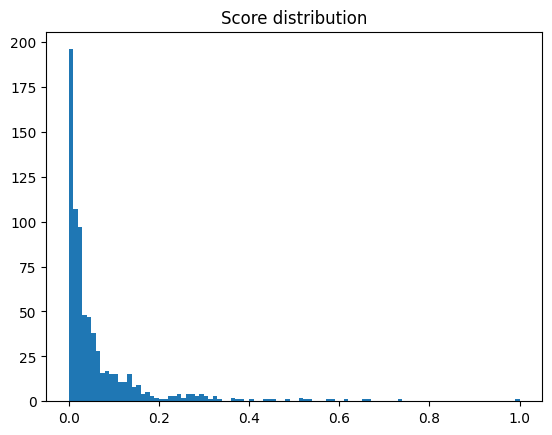

In [ ]:
plt.hist(df_cluj['score'], bins=100)
plt.title('Score distribution')
plt.show()

## Bucuresti subreddit

In [ ]:
df_bucuresti = pd.read_json('bucuresti_submissions (1).json',orient='index')
df_bucuresti = df_bucuresti.reset_index()
df_bucuresti = df_bucuresti.rename(columns={'index':'title', 0:'content', 1: 'num_comments', 2:'score', 3:'date'})

# Combine columns.
df_bucuresti['sum_score'] = df_bucuresti['num_comments'] + df_bucuresti['score']
df_bucuresti['full_text'] = df_bucuresti['title'] + '. ' + df_bucuresti['content']

# Transform.
df_bucuresti['num_comments'] = transform_column(df_bucuresti['num_comments'])
df_bucuresti['score'] = transform_column(df_bucuresti['score'])
df_bucuresti['sum_score'] = transform_column(df_bucuresti['sum_score'])
df_bucuresti

,title,content,num_comments,score,date,sum_score,full_text
0,Help Finding Vaguely Described Place,"""Long story short, I've found recently that in...",0.005780,0.000880,2018-01-08 15:33:19,0.002242,"Help Finding Vaguely Described Place. ""Long st..."
1,Looking for a shisha shop,I just moved to Bucharest and I'm a big shisha...,0.009634,0.000880,2018-01-17 15:00:13,0.003737,Looking for a shisha shop. I just moved to Buc...
2,Consiliul General al Municipiului București a ...,Alte două linii de tramvai din București vor f...,0.001927,0.001759,2018-03-28 15:17:54,0.001495,Consiliul General al Municipiului București a ...
3,Need Help!,"Hello, \n\nMe and some friends are visiting Bu...",0.005780,0.000000,2018-04-01 15:23:38,0.001495,"Need Help!. Hello, \n\nMe and some friends are..."
4,Dutch soccer team looking for friendly match i...,We are a Dutch amateur soccer team visiting Bu...,0.001927,0.001759,2018-04-06 12:30:03,0.001495,Dutch soccer team looking for friendly match i...
...,...,...,...,...,...,...,...
2910,Călugărițe...,"Care e treaba cu călugărițele, și ma refer la ...",0.069364,0.036060,2023-08-27 22:36:48,0.056801,"Călugărițe.... Care e treaba cu călugărițele, ..."
2911,"""Mi-a spus foarte clar, 150 lei/km"". Șoferii d...",,0.042389,0.034301,2023-08-20 09:02:23,0.044843,"""Mi-a spus foarte clar, 150 lei/km"". Șoferii d..."
2912,Povestioară,Ma scuzați pentru lunga poveste care urmează....,0.001927,0.035180,2023-06-30 18:48:06,0.029895,Povestioară. Ma scuzați pentru lunga poveste ...
2913,Acum 5 zile v-am scris despre situatia unui tr...,,0.023121,0.033421,2023-05-25 10:13:23,0.036622,Acum 5 zile v-am scris despre situatia unui tr...


In [ ]:
df_bucuresti = df_bucuresti[df_bucuresti.apply(is_romanian_post, axis=1)]
df_bucuresti

,title,content,num_comments,score,date,sum_score,full_text
2,Consiliul General al Municipiului București a ...,Alte două linii de tramvai din București vor f...,0.001927,0.001759,2018-03-28 15:17:54,0.001495,Consiliul General al Municipiului București a ...
12,Harta magazinelor de biciclism din Bucuresti,https://imgur.com/iSzwLtR,0.011561,0.004398,2018-06-28 18:16:55,0.007474,Harta magazinelor de biciclism din Bucuresti. ...
15,Turista pentru 2 zile/ looking for a guide,Salut. Stau in București pentru următoarele 2 ...,0.001927,0.000880,2018-07-16 20:44:40,0.000747,Turista pentru 2 zile/ looking for a guide. Sa...
16,Giulesti miroase a rahat,Hey! De cateva zile in zona Giulesti abia se p...,0.013487,0.003518,2018-07-17 07:37:10,0.007474,Giulesti miroase a rahat. Hey! De cateva zile ...
21,Tractare Autovehicul Bucuresti,"Salut,\n\nPoate cineva sa-mi recomande o firma...",0.001927,0.002639,2018-08-18 12:35:02,0.002242,"Tractare Autovehicul Bucuresti. Salut,\n\nPoat..."
...,...,...,...,...,...,...,...
2910,Călugărițe...,"Care e treaba cu călugărițele, și ma refer la ...",0.069364,0.036060,2023-08-27 22:36:48,0.056801,"Călugărițe.... Care e treaba cu călugărițele, ..."
2911,"""Mi-a spus foarte clar, 150 lei/km"". Șoferii d...",,0.042389,0.034301,2023-08-20 09:02:23,0.044843,"""Mi-a spus foarte clar, 150 lei/km"". Șoferii d..."
2912,Povestioară,Ma scuzați pentru lunga poveste care urmează....,0.001927,0.035180,2023-06-30 18:48:06,0.029895,Povestioară. Ma scuzați pentru lunga poveste ...
2913,Acum 5 zile v-am scris despre situatia unui tr...,,0.023121,0.033421,2023-05-25 10:13:23,0.036622,Acum 5 zile v-am scris despre situatia unui tr...


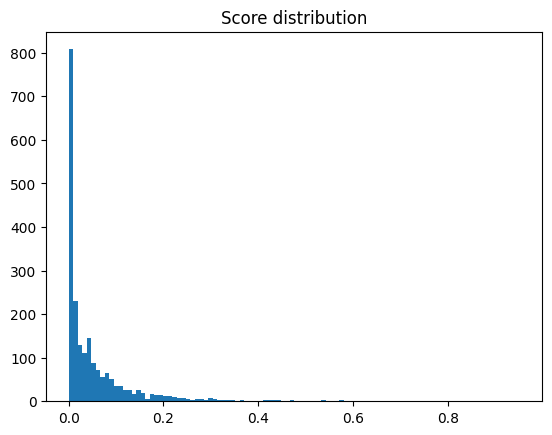

In [ ]:
plt.hist(df_bucuresti['score'], bins=100)
plt.title('Score distribution')
plt.show()

## Iasi subreddit

In [ ]:
df_iasi = pd.read_json('iasi_submissions (1).json',orient='index')
df_iasi = df_iasi.reset_index()
df_iasi = df_iasi.rename(columns={'index':'title', 0:'content', 1: 'num_comments', 2:'score', 3:'date'})

# Combine columns.
df_iasi['sum_score'] = df_iasi['num_comments'] + df_iasi['score']
df_iasi['full_text'] = df_iasi['title'] + '. ' + df_iasi['content']

# Transform.
df_iasi['num_comments'] = transform_column(df_iasi['num_comments'])
df_iasi['score'] = transform_column(df_iasi['score'])
df_iasi['sum_score'] = transform_column(df_iasi['sum_score'])
df_iasi

,title,content,num_comments,score,date,sum_score,full_text
0,"Daca dispar, continuati ce am inceput",,0.153086,1.000000,2023-09-14 17:41:55,1.000000,"Daca dispar, continuati ce am inceput."
1,De unde tot apar vacile astea?,,0.217284,0.855422,2023-09-22 17:12:39,0.903448,De unde tot apar vacile astea?.
2,Am gasit pisica! Va multumesc mult tuturor! A ...,,0.061728,0.561747,2023-03-26 21:14:54,0.547586,Am gasit pisica! Va multumesc mult tuturor! A ...
3,O bijuterie intr-o parcare din Iasi. Va place?,,0.051852,0.548193,2022-04-23 17:08:13,0.529655,O bijuterie intr-o parcare din Iasi. Va place?.
4,Vanzare de vape-uri cu nicotina minorilor.,"Iași, zona Palas, chiar în fața hotelului Mold...",0.204938,0.540663,2023-09-18 23:51:17,0.608276,Vanzare de vape-uri cu nicotina minorilor.. Ia...
...,...,...,...,...,...,...,...
959,Pe 9 septembrie se organizeaza o noua editie A...,,0.000000,0.001506,2023-09-06 16:55:05,0.000000,Pe 9 septembrie se organizeaza o noua editie A...
960,Clinica medicala de la USV Iasi?,Buna. A fost cineva cu animalutul la clinica m...,0.046914,0.003012,2023-08-31 11:45:34,0.027586,Clinica medicala de la USV Iasi?. Buna. A fost...
961,Sesizări online,Salutare! \nA folosit cineva (cu succes) pagin...,0.049383,0.001506,2023-08-30 17:10:46,0.027586,Sesizări online. Salutare! \nA folosit cineva ...
962,Casa in Iasi,Nu stiu daca asta este locul potrivit but Im g...,0.044444,0.000000,2023-08-29 14:55:34,0.023448,Casa in Iasi. Nu stiu daca asta este locul pot...


In [ ]:
df_iasi = df_iasi[df_iasi.apply(is_romanian_post, axis=1)]
df_iasi

,title,content,num_comments,score,date,sum_score,full_text
0,"Daca dispar, continuati ce am inceput",,0.153086,1.000000,2023-09-14 17:41:55,1.000000,"Daca dispar, continuati ce am inceput."
1,De unde tot apar vacile astea?,,0.217284,0.855422,2023-09-22 17:12:39,0.903448,De unde tot apar vacile astea?.
2,Am gasit pisica! Va multumesc mult tuturor! A ...,,0.061728,0.561747,2023-03-26 21:14:54,0.547586,Am gasit pisica! Va multumesc mult tuturor! A ...
3,O bijuterie intr-o parcare din Iasi. Va place?,,0.051852,0.548193,2022-04-23 17:08:13,0.529655,O bijuterie intr-o parcare din Iasi. Va place?.
4,Vanzare de vape-uri cu nicotina minorilor.,"Iași, zona Palas, chiar în fața hotelului Mold...",0.204938,0.540663,2023-09-18 23:51:17,0.608276,Vanzare de vape-uri cu nicotina minorilor.. Ia...
...,...,...,...,...,...,...,...
955,Cumpărat apartament fără agenții,Salutare!\n\nAm și eu de gând să cumpăr un apa...,0.019753,0.001506,2023-09-22 17:27:53,0.011034,Cumpărat apartament fără agenții. Salutare!\n\...
959,Pe 9 septembrie se organizeaza o noua editie A...,,0.000000,0.001506,2023-09-06 16:55:05,0.000000,Pe 9 septembrie se organizeaza o noua editie A...
960,Clinica medicala de la USV Iasi?,Buna. A fost cineva cu animalutul la clinica m...,0.046914,0.003012,2023-08-31 11:45:34,0.027586,Clinica medicala de la USV Iasi?. Buna. A fost...
961,Sesizări online,Salutare! \nA folosit cineva (cu succes) pagin...,0.049383,0.001506,2023-08-30 17:10:46,0.027586,Sesizări online. Salutare! \nA folosit cineva ...


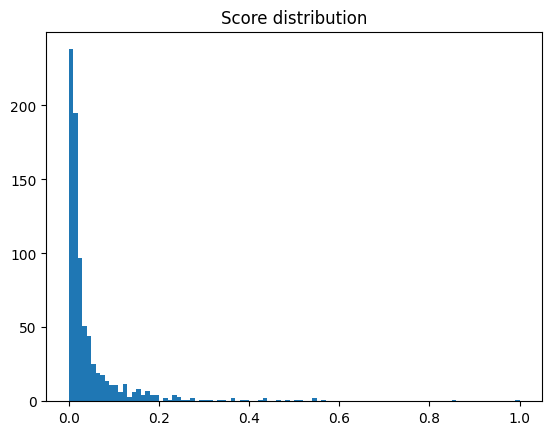

In [ ]:
plt.hist(df_iasi['score'], bins=100)
plt.title('Score distribution')
plt.show()

## Timisoara subreddit

In [ ]:
df_timisoara = pd.read_json('timisoara_submissions (1).json',orient='index')
df_timisoara = df_timisoara.reset_index()
df_timisoara = df_timisoara.rename(columns={'index':'title', 0:'content', 1: 'num_comments', 2:'score', 3:'date'})

# Combine columns.
df_timisoara['sum_score'] = df_timisoara['num_comments'] + df_timisoara['score']
df_timisoara['full_text'] = df_timisoara['title'] + '. ' + df_timisoara['content']

# Transform.
df_timisoara['num_comments'] = transform_column(df_timisoara['num_comments'])
df_timisoara['score'] = transform_column(df_timisoara['score'])
df_timisoara['sum_score'] = transform_column(df_timisoara['sum_score'])
df_timisoara

,title,content,num_comments,score,date,sum_score,full_text
0,Steag LGBT lângă steagul României la noul IKEA...,Păreri?,1.000000,1.000000,2023-05-17 10:59:12,1.000000,Steag LGBT lângă steagul României la noul IKEA...
1,Uite ca se poate!!!,,0.065649,0.771580,2023-09-25 13:47:47,0.443182,Uite ca se poate!!!.
2,În caz că vreți să vă angajați la New Yorker î...,Mi-am dat azi demisia și aici am o listă de mo...,0.254962,0.709163,2023-08-31 02:16:38,0.497869,În caz că vreți să vă angajați la New Yorker î...
3,"Timișoara o să devină mai verde, modernă și ma...",,0.178626,0.622842,2023-10-16 18:08:04,0.416193,"Timișoara o să devină mai verde, modernă și ma..."
4,De ce downgrade?,Aveam și noi o fântână fain decorată 😑,0.065649,0.564409,2023-06-05 14:48:18,0.332386,De ce downgrade?. Aveam și noi o fântână fain ...
...,...,...,...,...,...,...,...
973,Escape tonight?,,0.016794,0.001328,2023-04-01 18:27:49,0.008523,Escape tonight?.
974,Spatiu munca remote 1 zi,Salut. Ma voi afla vineri in Timișoara si am n...,0.018321,0.000000,2023-03-21 06:52:51,0.008523,Spatiu munca remote 1 zi. Salut. Ma voi afla v...
975,Stie cineva o locatie de unde se pot inchiria ...,,0.007634,0.002656,2023-03-15 11:34:27,0.004972,Stie cineva o locatie de unde se pot inchiria ...
976,PUZ in dezbatere publica a zonei dintre str Oi...,,0.000000,0.001328,2023-03-14 16:53:02,0.000710,PUZ in dezbatere publica a zonei dintre str Oi...


In [ ]:
df_timisoara = df_timisoara[df_timisoara.apply(is_romanian_post, axis=1)]
df_timisoara

,title,content,num_comments,score,date,sum_score,full_text
0,Steag LGBT lângă steagul României la noul IKEA...,Păreri?,1.000000,1.000000,2023-05-17 10:59:12,1.000000,Steag LGBT lângă steagul României la noul IKEA...
1,Uite ca se poate!!!,,0.065649,0.771580,2023-09-25 13:47:47,0.443182,Uite ca se poate!!!.
2,În caz că vreți să vă angajați la New Yorker î...,Mi-am dat azi demisia și aici am o listă de mo...,0.254962,0.709163,2023-08-31 02:16:38,0.497869,În caz că vreți să vă angajați la New Yorker î...
3,"Timișoara o să devină mai verde, modernă și ma...",,0.178626,0.622842,2023-10-16 18:08:04,0.416193,"Timișoara o să devină mai verde, modernă și ma..."
5,Soferii de la Tucano Cafe,,0.105344,0.416999,2023-05-05 18:26:17,0.272017,Soferii de la Tucano Cafe.
...,...,...,...,...,...,...,...
970,Locuri de muncă - limba poloneză,Hello! Poate mă puteți ajuta cu o sugestie. Av...,0.009160,0.001328,2023-04-20 12:57:35,0.004972,Locuri de muncă - limba poloneză. Hello! Poate...
971,Recomandare firma de curatenie/femeie de servici,As avea nevoie de ajutor pt spalat geamuri + c...,0.007634,0.001328,2023-04-04 22:22:20,0.004261,Recomandare firma de curatenie/femeie de servi...
972,Nouă galerie comercială în construcție la intr...,,0.004580,0.000000,2023-04-03 04:46:58,0.002131,Nouă galerie comercială în construcție la intr...
975,Stie cineva o locatie de unde se pot inchiria ...,,0.007634,0.002656,2023-03-15 11:34:27,0.004972,Stie cineva o locatie de unde se pot inchiria ...


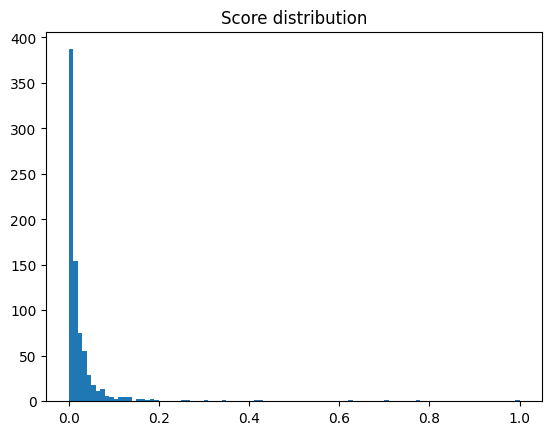

In [ ]:
plt.hist(df_timisoara['score'], bins=100)
plt.title('Score distribution')
plt.show()

# Combine dfs.

* Train = Romanian_submissions
* Test = Cluj + Iasi submissions  
* Validation = Bucuresti + Timisoara submissions


In [ ]:
df_train = df_romania
df_test = pd.concat([df_cluj, df_iasi, df_timisoara], ignore_index=True)
df_validation = pd.concat([df_bucuresti], ignore_index=True)

In [ ]:
# Load the dataset into a pandas dataframe.

df_train = shuffle(df_train)
df_validation = shuffle(df_validation)
df_test = shuffle(df_test)

print('Number of training sentences: {:,}\n'.format(df_train.shape[0]))
print('Number of validation sentences: {:,}\n'.format(df_validation.shape[0]))
print('Number of test sentences: {:,}\n'.format(df_test.shape[0]))

# Display 10 random rows from the data.
df_train.sample(10)

Number of training sentences: 23,645

Number of validation sentences: 2,113

Number of test sentences: 2,349



,title,content,num_comments,score,date,sum_score,full_text
20111,Și n-au învins | Contributors,,0.002381,0.006466,2014-11-03 14:53:17,0.005225,Și n-au învins | Contributors.
18097,"Clanul Carpaci, atacat cu un cocktail Molotov ...",,0.007143,0.030172,2014-09-12 18:19:57,0.020899,"Clanul Carpaci, atacat cu un cocktail Molotov ..."
1720,Haha! Joc cu protestatari si jandarmi,,0.008333,0.045259,2012-01-21 20:19:33,0.029258,Haha! Joc cu protestatari si jandarmi.
27890,Centrul orașului Câmpulung-Muscel pe la 1860,,0.010714,0.105603,2015-04-09 12:39:56,0.060606,Centrul orașului Câmpulung-Muscel pe la 1860.
16940,ELI5 ce-a facut Basescu?,"Why so much hate? \n\nAud peste tot ca ""ne-a f...",0.126190,0.040948,2014-08-09 14:54:54,0.130617,ELI5 ce-a facut Basescu?. Why so much hate? \n...
19309,Toată lumea votează Victor Ponta președinte! (...,,0.030952,0.034483,2014-10-16 16:11:12,0.043887,Toată lumea votează Victor Ponta președinte! (...
2306,"Mulți văd, puțini cunosc",,0.005952,0.127155,2012-03-31 00:20:12,0.066876,"Mulți văd, puțini cunosc."
4517,Țepari prin SMS: 0722005419 și 0734423180 (SCA...,Fiindca ieri si azi si eu si un amic am primit...,0.011905,0.023707,2012-10-09 22:28:16,0.021944,Țepari prin SMS: 0722005419 și 0734423180 (SCA...
14489,AAI ca o familie cu venituri medii este format...,,0.008333,0.028017,2014-05-15 16:37:06,0.020899,AAI ca o familie cu venituri medii este format...
11286,"Ce amintiri frumoase, mai draga!",,0.017857,0.122845,2014-01-17 17:28:21,0.075235,"Ce amintiri frumoase, mai draga!."


In [ ]:
def make_labels(raw_labels, median_score, pct75):
  labels = []
  for score in raw_labels:
    if score < median_score:
      labels.append(0)
    elif score >= median_score and score < pct75:
      labels.append(1)
    else:
      labels.append(2)
  return np.array(labels)

In [ ]:
# Get the lists of contents and their labels.
### TRAIN ###
contents_train = df_train.full_text.values
median_score = np.median(df_train.score.values)
labels_train = np.where(df_train.score.values > median_score, 1, 0)


### VALIDATION ###
contents_validation = df_validation.full_text.values
median_score = np.median(df_validation.score.values)
labels_validation = np.where(df_validation.score.values > median_score, 1, 0)

### TEST ###
contents_test = df_test.full_text.values
median_score = np.median(df_test.score.values)
labels_test = np.where(df_test.score.values > median_score, 1, 0)

In [ ]:
len(labels_train)

23645

In [ ]:
print("TRAIN")
# Print the original sentence.
print(' Original: ', contents_train[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(contents_train[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(contents_train[0])))

print("VALIDATION")
# Print the original sentence.
print(' Original: ', contents_validation[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(contents_validation[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(contents_validation[0])))

print("TEST")
# Print the original sentence.
print(' Original: ', contents_test[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(contents_test[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(contents_test[0])))

TRAIN
 Original:  Harta limbilor vorbite in Europa suprapusa pe conturul tarilor. 
Tokenized:  ['H', 'arta', 'Ġlimbilor', 'Ġvorbi', 'te', 'Ġin', 'ĠEuropa', 'Ġsuprap', 'usa', 'Ġpe', 'Ġconturul', 'Ġta', 'rilor', '.', 'Ġ']
Token IDs:  [40, 2331, 32241, 3654, 251, 317, 2596, 22825, 10338, 306, 35410, 660, 794, 14, 208]
VALIDATION
 Original:  Cluburi de revelion. Ceva idei de cluburi fără rezervare în noaptea de revelion? Eu și prietenii mei am fost cam nepăsători pe parcursul anului...
Fără cluburi doar cu rock/techno.. ceva mai romanesc cautam
Tokenized:  ['Club', 'uri', 'Ġde', 'Ġrevel', 'ion', '.', 'ĠCeva', 'Ġidei', 'Ġde', 'Ġcluburi', 'ĠfÄĥrÄĥ', 'Ġrezervare', 'ĠÃ®n', 'Ġnoaptea', 'Ġde', 'Ġrevel', 'ion', '?', 'ĠEu', 'ĠÈĻi', 'Ġprietenii', 'Ġmei', 'Ġam', 'Ġfost', 'Ġcam', 'ĠnepÄĥ', 'sÄĥtori', 'Ġpe', 'Ġparcursul', 'Ġanului', '...', 'Ċ', 'FÄĥrÄĥ', 'Ġcluburi', 'Ġdoar', 'Ġcu', 'Ġrock', '/', 'tech', 'no', '..', 'Ġceva', 'Ġmai', 'Ġromanesc', 'Ġcauta', 'm']
Token IDs:  [41408, 337, 253, 9970, 3115, 

# Stats dataset

In [ ]:
print("Posts train: ", len(contents_train))
print("Posts val: ", len(contents_validation))
print("Posts test: ", len(contents_test))

Posts train:  23645
Posts val:  2113
Posts test:  2349


In [ ]:
train_tokens_array = []
# Train
for index in range(len(contents_train)):
  if labels_train[index] == 1:
    train_tokens_array.append(len(tokenizer.tokenize(contents_train[index])))

val_tokens_array = []
# Validation
for index in range(len(contents_validation)):
  if labels_validation[index] == 1:
    val_tokens_array.append(len(tokenizer.tokenize(contents_validation[index])))

# Test
test_tokens_array = []
for index in range(len(contents_test)):
  if labels_test[index] == 1:
    test_tokens_array.append(len(tokenizer.tokenize(contents_test[index])))

In [ ]:
print(sum(train_tokens_array))
print(sum(val_tokens_array))
print(sum(test_tokens_array))

472841
81508
84361


In [ ]:
print("Posts train split")
print("Unpopular: ", sum(labels_train == 0))
print("Popular:", sum(labels_train == 1))

print("Posts validation split")
print("Unpopular: ", sum(labels_validation == 0))
print("Popular:", sum(labels_validation == 1))

print("Posts test split")
print("Unpopular: ", sum(labels_test == 0))
print("Popular:", sum(labels_test == 1))

Posts train split
Unpopular:  11849
Popular: 11796
Posts validation split
Unpopular:  1058
Popular: 1055
Posts test split
Unpopular:  1177
Popular: 1172


## Tokenize dataset

### Train

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids_train = []
attention_masks_train = []

# For every webpage content.
for content in contents_train:
    encoded_dict = tokenizer.encode_plus(
                        content,                   # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 120,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids_train.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks_train.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids_train = torch.cat(input_ids_train, dim=0)
attention_masks_train = torch.cat(attention_masks_train, dim=0)
labels_train = torch.tensor(labels_train)

# Print sentence 0, now as a list of IDs.
print('Original: ', contents_train[0])
print('Token IDs:', input_ids_train[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  Harta limbilor vorbite in Europa suprapusa pe conturul tarilor. 
Token IDs: tensor([   40,  2331, 32241,  3654,   251,   317,  2596, 22825, 10338,   306,
        35410,   660,   794,    14,   208,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0

### Validation

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids_validation = []
attention_masks_validation = []

# For every webpage content.
for content in contents_validation:
    encoded_dict = tokenizer.encode_plus(
                        content,                   # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 120,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids_validation.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks_validation.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids_validation = torch.cat(input_ids_validation, dim=0)
attention_masks_validation = torch.cat(attention_masks_validation, dim=0)
labels_validation = torch.tensor(labels_validation)

# Print sentence 0, now as a list of IDs.
print('Original: ', contents_validation[0])
print('Token IDs:', input_ids_validation[0])

Original:  Cluburi de revelion. Ceva idei de cluburi fără rezervare în noaptea de revelion? Eu și prietenii mei am fost cam nepăsători pe parcursul anului...
Fără cluburi doar cu rock/techno.. ceva mai romanesc cautam
Token IDs: tensor([41408,   337,   253,  9970,  3115,    14, 12265,  5096,   253, 17948,
          782, 24128,   260,  3515,   253,  9970,  3115,    31,   842,   334,
         5591,  3758,   442,   431,  1894, 11034, 21436,   306,  4675,  2271,
          495,   186, 34678, 17948,   775,   291, 13725,    15, 32499,  1361,
          370,   981,   349, 25688, 15583,    77,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0

### Test

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids_test = []
attention_masks_test = []

# For every webpage content.
for content in contents_test:
    encoded_dict = tokenizer.encode_plus(
                        content,                   # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 120,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids_test.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks_test.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids_test = torch.cat(input_ids_test, dim=0)
attention_masks_test = torch.cat(attention_masks_test, dim=0)
labels_test = torch.tensor(labels_test)

# Print sentence 0, now as a list of IDs.
print('Original: ', contents_test[0])
print('Token IDs:', input_ids_test[0])

Original:  Unde e cel mai bun burger din Iași în 2022?. Votați cel mai bun burger! Big5, Cheffa sau altul, care este preferatul vostru?
Token IDs: tensor([31258,   273,   672,   349,  1128,   326,  2620,   299,   310,  5399,
          260, 49476, 33543,  3776,  2343,   672,   349,  1128,   326,  2620,
          299,     1, 14364,    21,    12, 44376,  1030,   474,  3335,    12,
          327,   375,  8899,   390,  8009,    31,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,   

# Train model

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
train_dataset = TensorDataset(input_ids_train, attention_masks_train, labels_train)
validation_dataset = TensorDataset(input_ids_validation, attention_masks_validation, labels_validation)
test_dataset = TensorDataset(input_ids_test, attention_masks_test, labels_test)

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size, # Trains with this batch size.
            num_workers=0
        )

validation_dataloader = DataLoader(
            validation_dataset, # The validation samples.
            sampler = RandomSampler(validation_dataset), # Pull out batches sequentially.
            batch_size = batch_size, num_workers=0 # Evaluate with this batch size.
        )

test_dataloader = DataLoader(test_dataset,
                             sampler=SequentialSampler(test_dataset),
                             batch_size=batch_size)

In [ ]:
class CustomGPTModel(torch.nn.Module):
    def __init__(self):
          super(CustomGPTModel, self).__init__()
          self.gpt = GPT2ForSequenceClassification.from_pretrained("readerbench/RoGPT2-base")
          self.gpt.config.pad_token_id = self.gpt.config.eos_token_id

    def forward(self, ids, mask):
          sequence_output = self.gpt(
               ids, attention_mask=mask)
          soft_output = torch.nn.functional.softmax(sequence_output[0], dim=1)
          return soft_output

In [ ]:
model = CustomGPTModel()

# # Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at readerbench/RoGPT2-base and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CustomGPTModel(
  (gpt): GPT2ForSequenceClassification(
    (transformer): GPT2Model(
      (wte): Embedding(50257, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-11): 12 x GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D()
            (c_proj): Conv1D()
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D()
            (c_proj): Conv1D()
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (score): Linear(in_features=768, out_features=2, bias=False)
  )
)

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 5e-7, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-7 # args.adam_epsilon  - default is 1e-8.
                )
criterion = torch.nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 5

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
import numpy as np
from sklearn.metrics import f1_score

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
def compute_metrics(y_pred, y_true):
  y_pred = np.argmax(y_pred, axis=1).flatten()
  macro_f1 = f1_score(y_true, y_pred, average='macro')
  # Popular - label 1
  TP_pop = 0 # y_true = 1 si y_pred = 1
  FP_pop = 0 # y_true = 0 si y_pred = 1
  FN_pop = 0 # y_true = 1 si y_pred = 0
  # Unpopular - label 0
  TP_unpop = 0 # y_true = 0 si y_pred = 0
  FP_unpop = 0 # y_true = 1 si y_pred = 0
  FN_unpop = 0 # y_true = 0 si y_pred = 1
  n = len(y_pred)
  for index in range(n):
    # Popular
    if y_true[index] == 1:
      if y_pred[index] == 1:
        TP_pop += 1
      if y_pred[index] == 0:
        FN_pop += 1
        FP_unpop += 1
    else:
    # Unpopular y_true[index] == 0
      if y_pred[index] == 0:
        TP_unpop += 1
      if y_pred[index] == 1:
        FN_unpop += 1
        FP_pop += 1

  P_pop = 0 if TP_pop + FP_pop == 0 else TP_pop / (TP_pop + FP_pop)
  R_pop = 0 if TP_pop + FN_pop == 0 else TP_pop / (TP_pop + FN_pop)
  P_unpop = 0 if TP_unpop + FP_unpop == 0 else TP_unpop / (TP_unpop + FP_unpop)
  R_unpop = 0 if TP_unpop + FN_unpop == 0 else TP_unpop / (TP_unpop + FN_unpop)

  return (macro_f1, P_pop, R_pop, P_unpop, R_unpop)

In [ ]:
import random
import numpy as np
import os

seed_val = 42

# random.seed(seed_val)
# np.random.seed(seed_val)
# torch.manual_seed(seed_val)
# torch.cuda.manual_seed_all(seed_val)

criterion = torch.nn.CrossEntropyLoss() ## If required define your own criterion


# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(b_input_ids, b_input_mask)
        loss = criterion(outputs, b_labels)

        total_train_loss += loss.item()


        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.4f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    total_eval_f1 = 0
    total_eval_p_pop = 0
    total_eval_r_pop = 0
    total_eval_p_unpop = 0
    total_eval_r_unpop = 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids, mask=b_input_mask)

        loss = criterion(outputs, b_labels)
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        predicted_labels = outputs.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(predicted_labels, label_ids)
        (f1, p_pop, r_pop, p_unpop, r_unpop) = compute_metrics(predicted_labels, label_ids)
        total_eval_f1 += f1
        total_eval_p_pop += p_pop
        total_eval_p_unpop += p_unpop
        total_eval_r_pop += r_pop
        total_eval_r_unpop += r_unpop
    # Calculate the average loss over all of the batches.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    avg_val_f1 = total_eval_f1 / len(validation_dataloader)
    avg_val_p_pop = total_eval_p_pop / len(validation_dataloader)
    avg_val_r_pop = total_eval_r_pop / len(validation_dataloader)
    avg_val_p_unpop = total_eval_p_unpop / len(validation_dataloader)
    avg_val_r_unpop = total_eval_r_unpop / len(validation_dataloader)
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    print("  Accuracy: {0:.4f}".format(avg_val_accuracy))
    print("  Validation Loss: {0:.4f}".format(avg_val_loss))
    print("  Macro F1: {0:.4f}".format(avg_val_f1))
    print("  Precision popular: {0:.4f}".format(avg_val_p_pop))
    print("  Recall popular: {0:.4f}".format(avg_val_r_pop))
    print("  Precision unpopular: {0:.4f}".format(avg_val_p_unpop))
    print("  Recall unpopular: {0:.4f}".format(avg_val_r_unpop))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Acc.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...
  Batch    40  of    739.    Elapsed: 0:00:09.
  Batch    80  of    739.    Elapsed: 0:00:18.
  Batch   120  of    739.    Elapsed: 0:00:27.
  Batch   160  of    739.    Elapsed: 0:00:36.
  Batch   200  of    739.    Elapsed: 0:00:45.
  Batch   240  of    739.    Elapsed: 0:00:54.
  Batch   280  of    739.    Elapsed: 0:01:03.
  Batch   320  of    739.    Elapsed: 0:01:12.
  Batch   360  of    739.    Elapsed: 0:01:21.
  Batch   400  of    739.    Elapsed: 0:01:30.
  Batch   440  of    739.    Elapsed: 0:01:39.
  Batch   480  of    739.    Elapsed: 0:01:48.
  Batch   520  of    739.    Elapsed: 0:01:57.
  Batch   560  of    739.    Elapsed: 0:02:06.
  Batch   600  of    739.    Elapsed: 0:02:15.
  Batch   640  of    739.    Elapsed: 0:02:24.
  Batch   680  of    739.    Elapsed: 0:02:33.
  Batch   720  of    739.    Elapsed: 0:02:42.

  Average training loss: 0.6946
  Training epoch took: 0:02:46

Running Validation...
  Accuracy: 0.5910
  Val

In [ ]:
import pandas as pd

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Acc.,Training Time,Validation Time
epoch,,,,,
1,0.694607,0.678434,0.590951,0:02:46,0:00:05
2,0.689015,0.665208,0.627332,0:02:46,0:00:05
3,0.686204,0.655511,0.660448,0:02:46,0:00:05
4,0.684131,0.651885,0.666978,0:02:46,0:00:05
5,0.683763,0.654142,0.652519,0:02:46,0:00:05


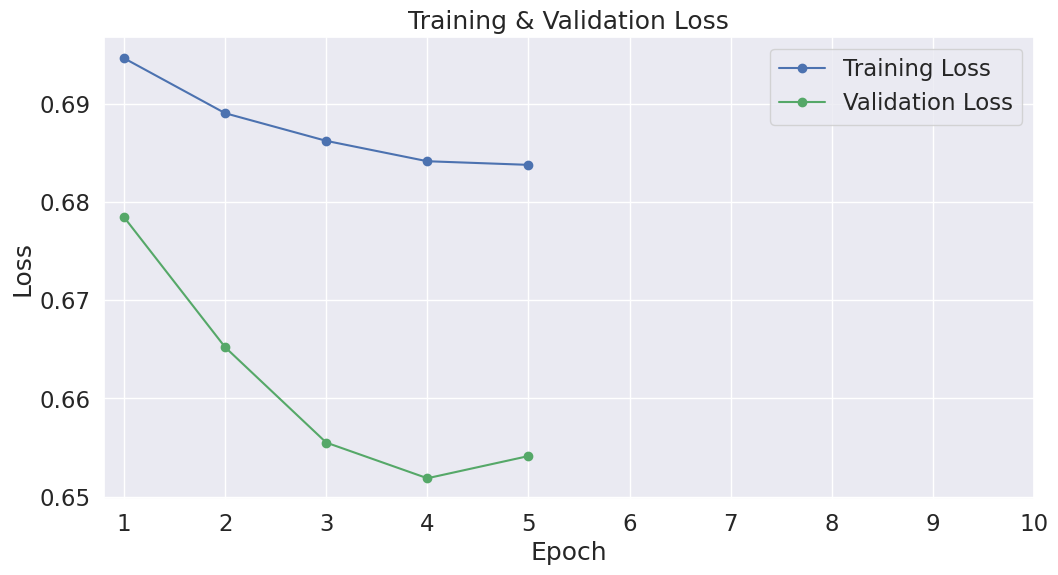

In [ ]:
import matplotlib.pyplot as plt
# % matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training Loss")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation Loss")
# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

plt.show()

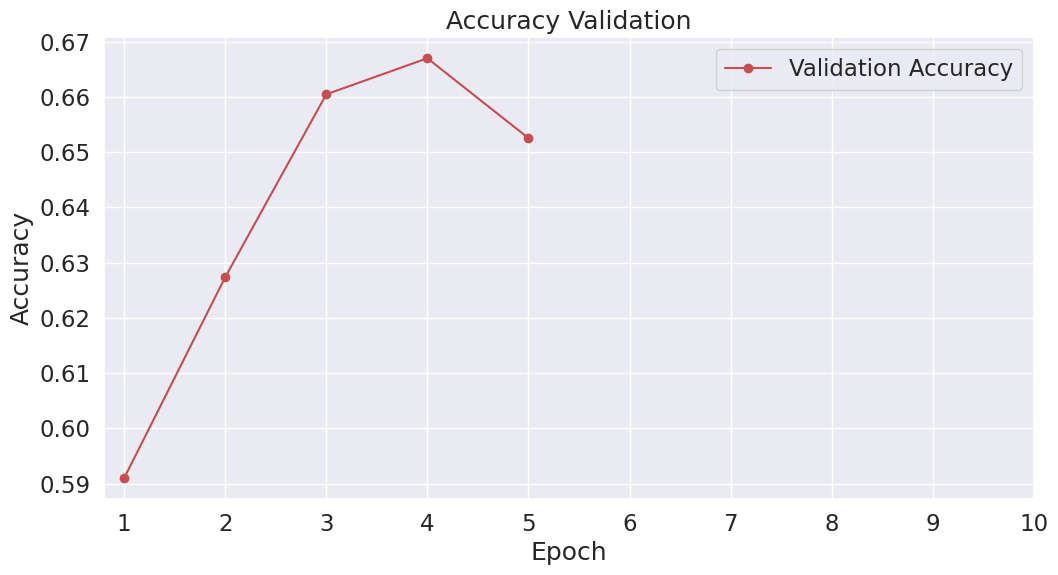

In [ ]:
import matplotlib.pyplot as plt
# % matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Valid. Acc.'], 'r-o', label="Validation Accuracy")
# Label the plot.
plt.title("Accuracy Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

plt.show()

## 5.2. Evaluate on Test Set


In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids_test)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

total_loss = 0
# Predict
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      outputs = model(b_input_ids, mask=b_input_mask)

  # Move logits and labels to CPU
  predicted_labels = outputs.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(predicted_labels)
  true_labels.append(label_ids)
  loss = criterion(outputs, b_labels)
  total_loss += loss.item()

print('    DONE.')
print("  Test Loss: {0:.4f}".format(total_loss/len(test_dataloader)))

Predicting labels for 2,349 test sentences...
    DONE.
  Test Loss: 0.6681


In [ ]:
sum_accuracy = 0
total_test_f1 = 0
total_test_p_pop = 0
total_test_r_pop = 0
total_test_p_unpop = 0
total_test_r_unpop = 0


print(len(predictions))
for index in range(len(predictions)):
  (f1, p_pop, r_pop, p_unpop, r_unpop) = compute_metrics(predictions[index], true_labels[index])
  total_test_f1 += f1
  total_test_p_pop += p_pop
  total_test_p_unpop += p_unpop
  total_test_r_pop += r_pop
  total_test_r_unpop += r_unpop
  curr_acc = flat_accuracy(predictions[index], true_labels[index])
  sum_accuracy += curr_acc

74


In [ ]:
avg_test_accuracy = sum_accuracy / len(predictions)
avg_test_f1 = total_test_f1 / len(predictions)
avg_test_p_pop = total_test_p_pop / len(predictions)
avg_test_r_pop = total_test_r_pop / len(predictions)
avg_test_p_unpop = total_test_p_unpop / len(predictions)
avg_test_r_unpop = total_test_r_unpop / len(predictions)
print("  Accuracy: {0:.4f}".format(avg_test_accuracy))
print("  Macro F1: {0:.4f}".format(avg_test_f1))
print("  Precision popular: {0:.4f}".format(avg_test_p_pop))
print("  Recall popular: {0:.4f}".format(avg_test_r_pop))
print("  Precision unpopular: {0:.4f}".format(avg_test_p_unpop))
print("  Recall unpopular: {0:.4f}".format(avg_test_r_unpop))

  Accuracy: 0.6135
  Macro F1: 0.6060
  Precision popular: 0.6146
  Recall popular: 0.5933
  Precision unpopular: 0.6146
  Recall unpopular: 0.6331
